### Code

In [2]:
import os
import json
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


In [1]:
def report_accuracy(data_root, result_root, experiments):
    # Iterate over experiments
    for exp in experiments:
        print(f"Experiment: {exp}")
        accs = []
        classwise_accs = []
        all_classes = set()

        fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots for confusion matrices

        for split in range(5):
            # Load data file
            df = pd.read_csv(os.path.join(data_root, exp, f"data_split{split}.csv"), header=None)
            # Load evaluation file
            eval_path = os.path.join(result_root, exp, f"split{split}", 'evaluation.pt')
            ev = torch.load(eval_path)

            # Extract necessary data
            id_list = ev['id']
            folder_list = ev['folder']
            # true_label = np.array(ev['true_label']['age'])
            true_label = df[3].to_numpy()
            predicted_label = np.array(ev['predicted_label']['age'])

            # Filter test indices where folder == 2
            test_indices = [i for i in range(len(id_list)) if folder_list[i] == 2]

            if not test_indices:  # Skip if no test samples for this split
                print(f"split{split} has no test samples.")
                continue

            y_true = true_label[test_indices]
            y_pred = predicted_label[test_indices]

            # Compute accuracy
            test_accuracy = accuracy_score(y_true, y_pred)
            accs.append(test_accuracy)

            # Compute classwise accuracy
            report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
            class_accuracies = {int(cls): report[cls]['recall'] for cls in report if cls.isdigit()}  # Extract recall (per-class accuracy)
            classwise_accs.append(class_accuracies)
            all_classes.update(class_accuracies.keys())  # Collect all unique class labels

            # Ensure sorted order of classwise accuracies
            sorted_classes = sorted(all_classes)
            classwise_acc_list = [class_accuracies.get(cls, 0.0) for cls in sorted_classes]

            # Print accuracy for this split
            classwise_str = ", ".join(f"{acc:.4f}" for acc in classwise_acc_list)
            print(f"split{split} accuracy/class-wise-accuracy\t=\t{test_accuracy:.4f} / {classwise_str}")

            # Plot confusion matrix
            cm = confusion_matrix(y_true, y_pred, labels=sorted_classes)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes, ax=axes[split])
            axes[split].set_title(f"Split {split}")
            axes[split].set_xlabel("Predicted")
            axes[split].set_ylabel("True")

        # Compute mean and std accuracy over splits
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        print(f"\naccuracy over splits: {mean_acc:.4f}  ± {std_acc:.4f}\n")

        # Compute mean and std of classwise accuracy
        classwise_mean_acc = {cls: np.mean([accs[cls] for accs in classwise_accs if cls in accs]) for cls in all_classes}
        classwise_std_acc = {cls: np.std([accs[cls] for accs in classwise_accs if cls in accs]) for cls in all_classes}

        # Sort classwise accuracy by class index
        sorted_classes = sorted(classwise_mean_acc.keys())

        print("Classwise Mean Accuracy (Sorted):")
        for cls in sorted_classes:
            print(f"Class {cls}: {classwise_mean_acc[cls]:.4f} ± {classwise_std_acc[cls]:.4f}")

        plt.tight_layout()
        plt.show()  # Display confusion matrices
        print("\n" + "="*50 + "\n")


### 4090 Experiments

Experiment: Adience_256x256_resnet50_imagenet_dldl_v2_clean
split0 accuracy/class-wise-accuracy	=	0.5828 / 0.8737, 0.6333, 0.4382, 0.2599, 0.8338, 0.4024, 0.1203, 0.1518
split1 accuracy/class-wise-accuracy	=	0.5419 / 0.8874, 0.6471, 0.4205, 0.3397, 0.6742, 0.5411, 0.3462, 0.2881
split2 accuracy/class-wise-accuracy	=	0.6100 / 0.6494, 0.7849, 0.5819, 0.2000, 0.8102, 0.3732, 0.3250, 0.4703
split3 accuracy/class-wise-accuracy	=	0.4835 / 0.8214, 0.6542, 0.3172, 0.3181, 0.7465, 0.4165, 0.3836, 0.3782
split4 accuracy/class-wise-accuracy	=	0.6242 / 0.8365, 0.4777, 0.6620, 0.4079, 0.6871, 0.4386, 0.3151, 0.3381

accuracy over splits: 0.5685  ± 0.0509

Classwise Mean Accuracy (Sorted):
Class 0: 0.8137 ± 0.0855
Class 1: 0.6394 ± 0.0976
Class 2: 0.4840 ± 0.1227
Class 3: 0.3051 ± 0.0707
Class 4: 0.7504 ± 0.0638
Class 5: 0.4344 ± 0.0574
Class 6: 0.2980 ± 0.0919
Class 7: 0.3253 ± 0.1053


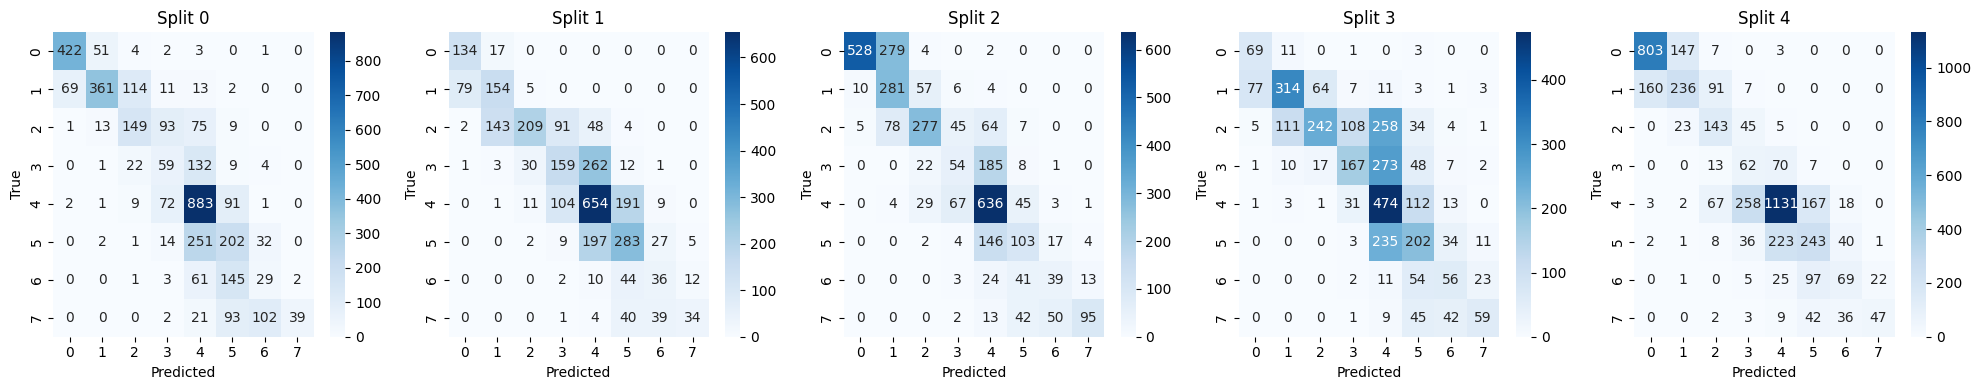



Experiment: Adience_256x256_resnet50_imagenet_dldl_v2_noisy
split0 accuracy/class-wise-accuracy	=	0.5056 / 0.8323, 0.5702, 0.3471, 0.3833, 0.6742, 0.3207, 0.1411, 0.0739
split1 accuracy/class-wise-accuracy	=	0.4484 / 0.8278, 0.4580, 0.3682, 0.4509, 0.5722, 0.2639, 0.3654, 0.1441
split2 accuracy/class-wise-accuracy	=	0.4345 / 0.3321, 0.7402, 0.3487, 0.2111, 0.6548, 0.3152, 0.3417, 0.1683
split3 accuracy/class-wise-accuracy	=	0.3644 / 0.5833, 0.4292, 0.2307, 0.2400, 0.6819, 0.2742, 0.3699, 0.1026
split4 accuracy/class-wise-accuracy	=	0.4689 / 0.4594, 0.5486, 0.4537, 0.3224, 0.5705, 0.4134, 0.1096, 0.0216

accuracy over splits: 0.4444  ± 0.0466

Classwise Mean Accuracy (Sorted):
Class 0: 0.6070 ± 0.1987
Class 1: 0.5492 ± 0.1092
Class 2: 0.3497 ± 0.0712
Class 3: 0.3215 ± 0.0887
Class 4: 0.6307 ± 0.0493
Class 5: 0.3175 ± 0.0528
Class 6: 0.2655 ± 0.1153
Class 7: 0.1021 ± 0.0518


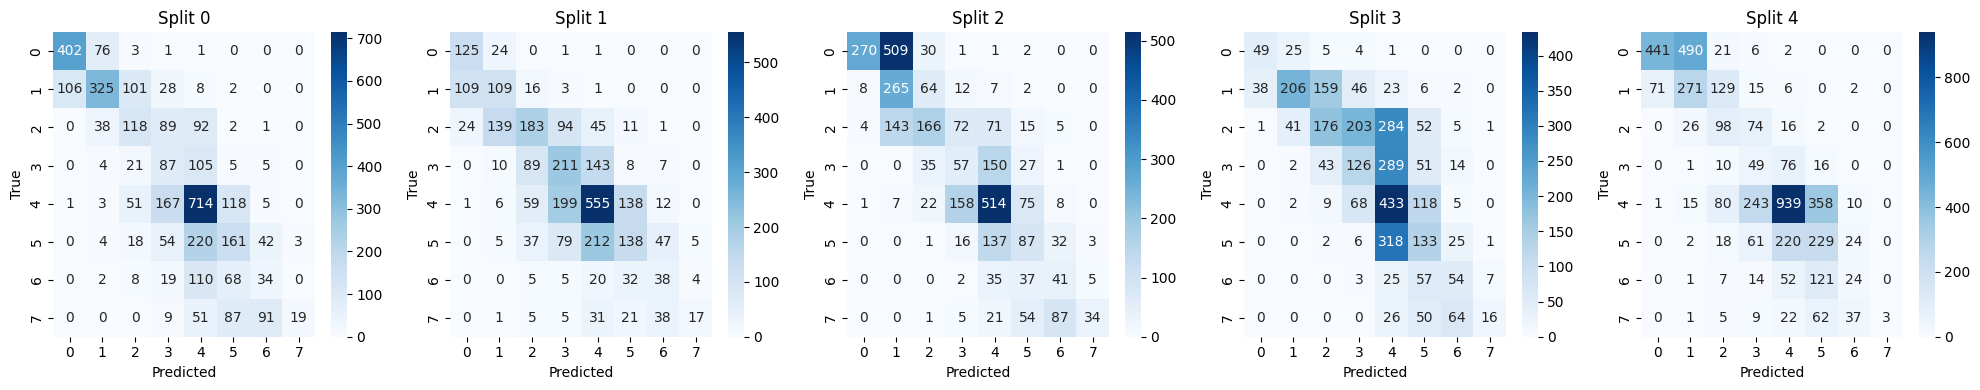



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_carl
split0 accuracy/class-wise-accuracy	=	0.6094 / 0.8882, 0.6930, 0.3235, 0.2819, 0.8584, 0.4462, 0.1826, 0.2607
split1 accuracy/class-wise-accuracy	=	0.5914 / 0.9272, 0.4496, 0.4950, 0.5449, 0.7515, 0.5143, 0.4327, 0.2034
split2 accuracy/class-wise-accuracy	=	0.6203 / 0.7122, 0.7905, 0.5609, 0.4667, 0.8051, 0.2681, 0.1750, 0.3218
split3 accuracy/class-wise-accuracy	=	0.5626 / 0.9167, 0.7229, 0.4889, 0.5410, 0.7496, 0.4536, 0.3082, 0.1282
split4 accuracy/class-wise-accuracy	=	0.6644 / 0.7750, 0.8097, 0.6343, 0.3289, 0.7582, 0.3953, 0.4064, 0.1655

accuracy over splits: 0.6096  ± 0.0336

Classwise Mean Accuracy (Sorted):
Class 0: 0.8438 ± 0.0852
Class 1: 0.6931 ± 0.1291
Class 2: 0.5005 ± 0.1030
Class 3: 0.4327 ± 0.1086
Class 4: 0.7846 ± 0.0421
Class 5: 0.4155 ± 0.0828
Class 6: 0.3010 ± 0.1081
Class 7: 0.2159 ± 0.0687


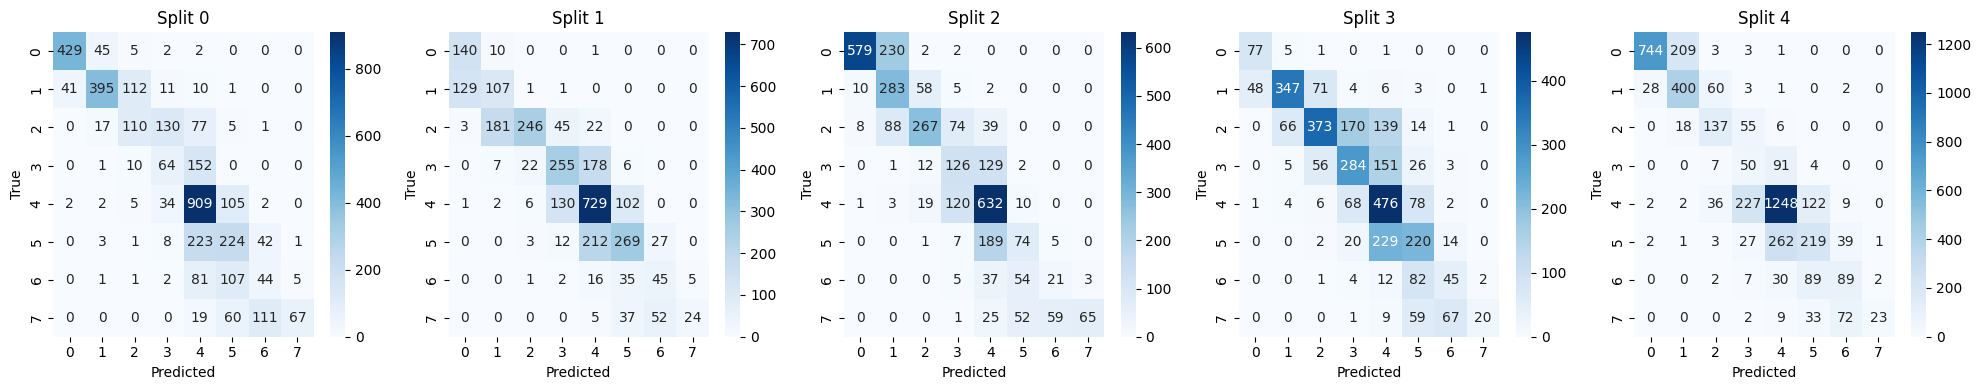



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v4
split0 accuracy/class-wise-accuracy	=	0.5031 / 0.6563, 0.7649, 0.3441, 0.3128, 0.6383, 0.3665, 0.1992, 0.0078
split1 accuracy/class-wise-accuracy	=	0.5011 / 0.8742, 0.6218, 0.3239, 0.3739, 0.6835, 0.3652, 0.3750, 0.2458
split2 accuracy/class-wise-accuracy	=	0.5164 / 0.6986, 0.6927, 0.4685, 0.3889, 0.5809, 0.3043, 0.1667, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4065 / 0.9286, 0.5500, 0.2936, 0.3124, 0.7260, 0.1794, 0.3562, 0.0064
split4 accuracy/class-wise-accuracy	=	0.5772 / 0.6740, 0.6235, 0.3009, 0.2171, 0.7321, 0.3718, 0.2785, 0.0216

accuracy over splits: 0.5009  ± 0.0547

Classwise Mean Accuracy (Sorted):
Class 0: 0.7663 ± 0.1124
Class 1: 0.6506 ± 0.0728
Class 2: 0.3462 ± 0.0637
Class 3: 0.3210 ± 0.0606
Class 4: 0.6722 ± 0.0567
Class 5: 0.3175 ± 0.0733
Class 6: 0.2751 ± 0.0826
Class 7: 0.0563 ± 0.0950


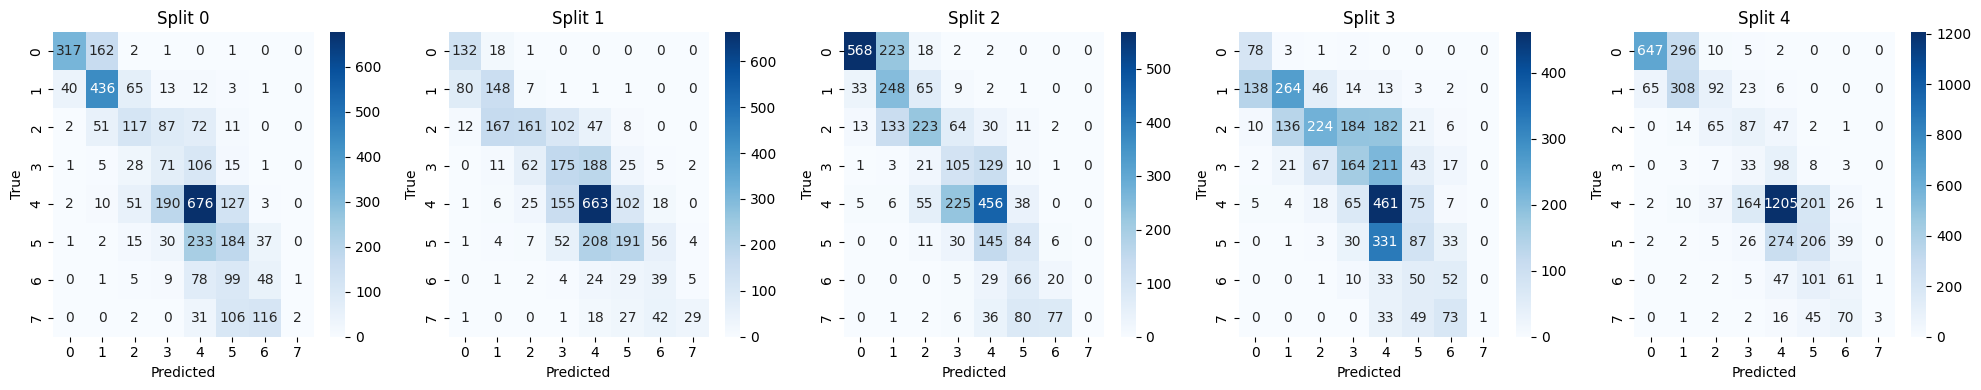



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v5
split0 accuracy/class-wise-accuracy	=	0.5300 / 0.6335, 0.8123, 0.3000, 0.2819, 0.7545, 0.3207, 0.1452, 0.0778
split1 accuracy/class-wise-accuracy	=	0.4904 / 0.9404, 0.4958, 0.2656, 0.3098, 0.7619, 0.3652, 0.3365, 0.0254
split2 accuracy/class-wise-accuracy	=	0.5164 / 0.5843, 0.7961, 0.4013, 0.2926, 0.6739, 0.3768, 0.3333, 0.0050
split3 accuracy/class-wise-accuracy	=	0.4090 / 0.8452, 0.5854, 0.2438, 0.3619, 0.7402, 0.2021, 0.2808, 0.0128
split4 accuracy/class-wise-accuracy	=	0.5845 / 0.6479, 0.7308, 0.3426, 0.1645, 0.7783, 0.3123, 0.1050, 0.0072

accuracy over splits: 0.5060  ± 0.0574

Classwise Mean Accuracy (Sorted):
Class 0: 0.7303 ± 0.1377
Class 1: 0.6841 ± 0.1236
Class 2: 0.3106 ± 0.0563
Class 3: 0.2821 ± 0.0649
Class 4: 0.7417 ± 0.0361
Class 5: 0.3154 ± 0.0619
Class 6: 0.2402 ± 0.0968
Class 7: 0.0256 ± 0.0270


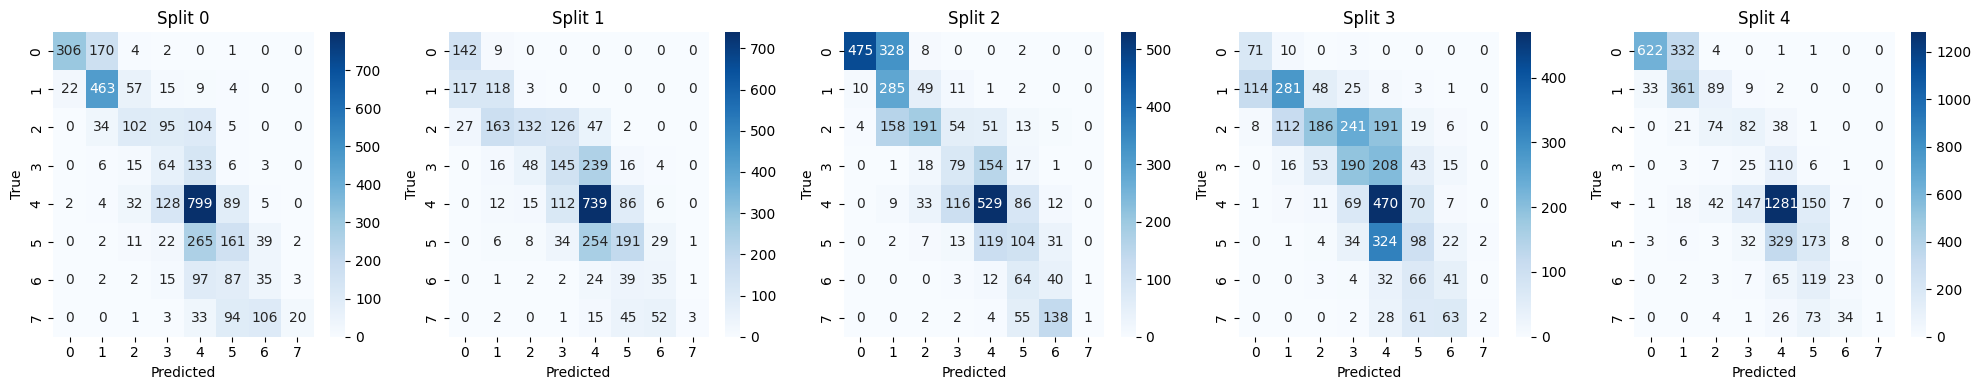



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_sigma
split0 accuracy/class-wise-accuracy	=	0.4735 / 0.5569, 0.6772, 0.2971, 0.3656, 0.6638, 0.2908, 0.1867, 0.0350
split1 accuracy/class-wise-accuracy	=	0.4493 / 0.7351, 0.6303, 0.3441, 0.4316, 0.5155, 0.3939, 0.2212, 0.1356
split2 accuracy/class-wise-accuracy	=	0.4267 / 0.4945, 0.6117, 0.3697, 0.3630, 0.5096, 0.2210, 0.1750, 0.1535
split3 accuracy/class-wise-accuracy	=	0.3754 / 0.5476, 0.5104, 0.2883, 0.2610, 0.6961, 0.1670, 0.2534, 0.1346
split4 accuracy/class-wise-accuracy	=	0.4817 / 0.4531, 0.5668, 0.3796, 0.2632, 0.6118, 0.4170, 0.1416, 0.0288

accuracy over splits: 0.4413  ± 0.0382

Classwise Mean Accuracy (Sorted):
Class 0: 0.5574 ± 0.0964
Class 1: 0.5993 ± 0.0568
Class 2: 0.3358 ± 0.0371
Class 3: 0.3369 ± 0.0659
Class 4: 0.5993 ± 0.0759
Class 5: 0.2979 ± 0.0964
Class 6: 0.1956 ± 0.0385
Class 7: 0.0975 ± 0.0540


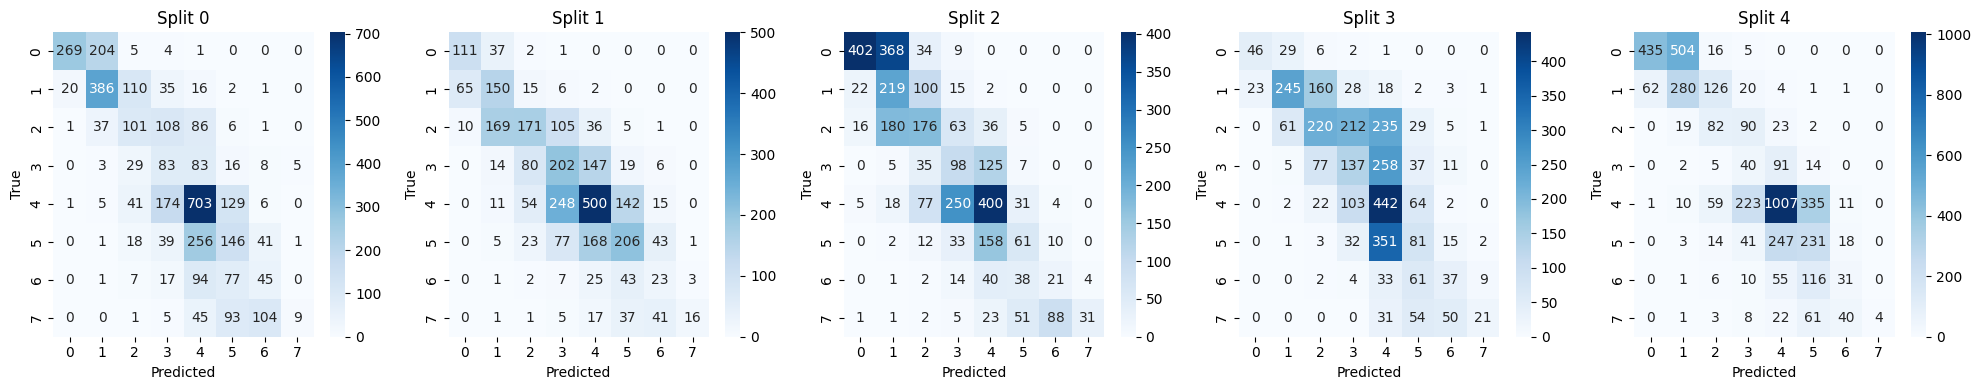



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_mean
split0 accuracy/class-wise-accuracy	=	0.4917 / 0.6232, 0.6193, 0.2824, 0.4185, 0.8206, 0.1853, 0.0083, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5106 / 0.8543, 0.6429, 0.3099, 0.4530, 0.7443, 0.3518, 0.1058, 0.0169
split2 accuracy/class-wise-accuracy	=	0.4758 / 0.5904, 0.7765, 0.4202, 0.5593, 0.5159, 0.1630, 0.0833, 0.0050
split3 accuracy/class-wise-accuracy	=	0.4184 / 0.7024, 0.6271, 0.2726, 0.2857, 0.7827, 0.2948, 0.0616, 0.0192
split4 accuracy/class-wise-accuracy	=	0.5856 / 0.7667, 0.5304, 0.3148, 0.3947, 0.7789, 0.2581, 0.0639, 0.0000

accuracy over splits: 0.4964  ± 0.0542

Classwise Mean Accuracy (Sorted):
Class 0: 0.7074 ± 0.0958
Class 1: 0.6392 ± 0.0791
Class 2: 0.3200 ± 0.0526
Class 3: 0.4222 ± 0.0885
Class 4: 0.7285 ± 0.1090
Class 5: 0.2506 ± 0.0696
Class 6: 0.0646 ± 0.0323
Class 7: 0.0082 ± 0.0083


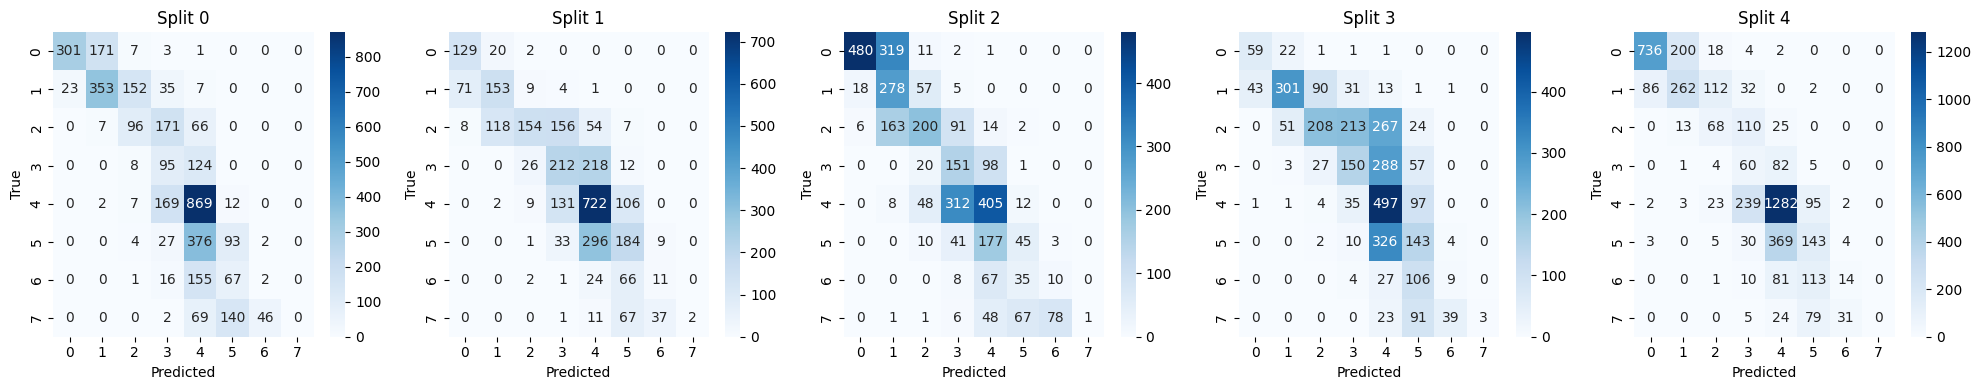



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip
split0 accuracy/class-wise-accuracy	=	0.4795 / 0.5404, 0.5947, 0.2471, 0.3965, 0.8319, 0.2112, 0.0124, 0.0000
split1 accuracy/class-wise-accuracy	=	0.4871 / 0.9007, 0.6092, 0.1932, 0.4466, 0.8258, 0.2008, 0.0288, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4824 / 0.5892, 0.6508, 0.4034, 0.4852, 0.6777, 0.0906, 0.0000, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4243 / 0.8095, 0.6937, 0.2294, 0.3505, 0.8866, 0.1278, 0.0274, 0.0000
split4 accuracy/class-wise-accuracy	=	0.4986 / 0.2740, 0.7308, 0.1852, 0.3026, 0.7837, 0.3321, 0.0000, 0.0000

accuracy over splits: 0.4744  ± 0.0259

Classwise Mean Accuracy (Sorted):
Class 0: 0.6227 ± 0.2199
Class 1: 0.6559 ± 0.0510
Class 2: 0.2516 ± 0.0792
Class 3: 0.3963 ± 0.0653
Class 4: 0.8011 ± 0.0699
Class 5: 0.1925 ± 0.0830
Class 6: 0.0137 ± 0.0126
Class 7: 0.0000 ± 0.0000


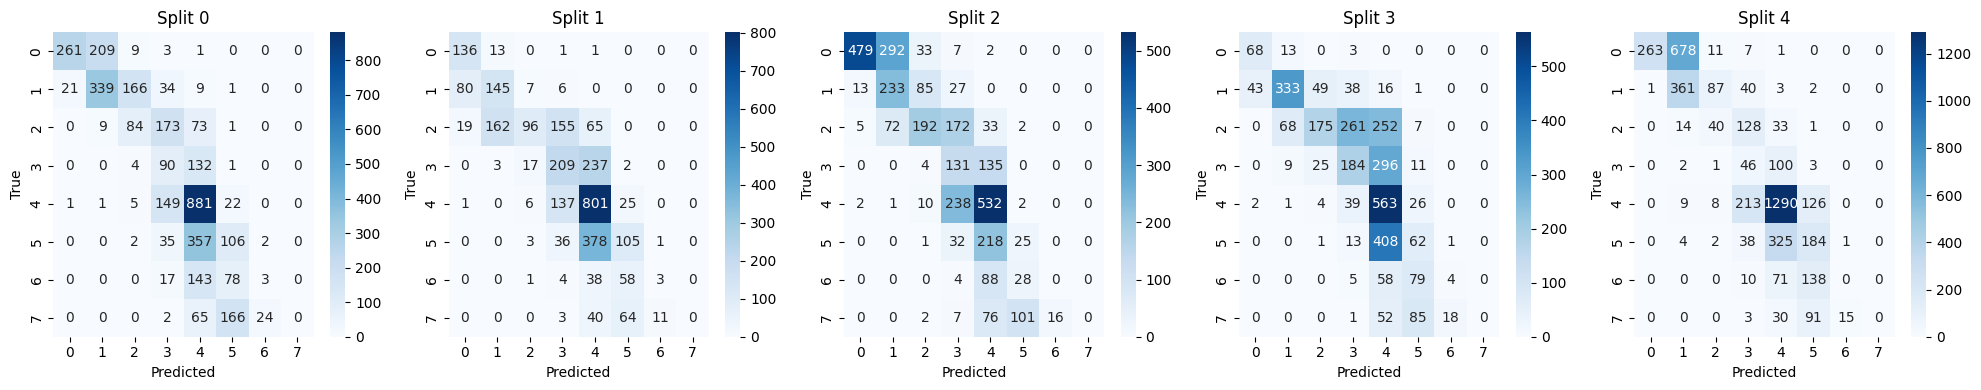



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip_v2
split0 accuracy/class-wise-accuracy	=	0.4795 / 0.5404, 0.5947, 0.2471, 0.3965, 0.8319, 0.2112, 0.0124, 0.0000
split1 accuracy/class-wise-accuracy	=	0.4871 / 0.9007, 0.6092, 0.1932, 0.4466, 0.8258, 0.2008, 0.0288, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4824 / 0.5892, 0.6508, 0.4034, 0.4852, 0.6777, 0.0906, 0.0000, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4243 / 0.8095, 0.6937, 0.2294, 0.3505, 0.8866, 0.1278, 0.0274, 0.0000
split4 accuracy/class-wise-accuracy	=	0.4986 / 0.2740, 0.7308, 0.1852, 0.3026, 0.7837, 0.3321, 0.0000, 0.0000

accuracy over splits: 0.4744  ± 0.0259

Classwise Mean Accuracy (Sorted):
Class 0: 0.6227 ± 0.2199
Class 1: 0.6559 ± 0.0510
Class 2: 0.2516 ± 0.0792
Class 3: 0.3963 ± 0.0653
Class 4: 0.8011 ± 0.0699
Class 5: 0.1925 ± 0.0830
Class 6: 0.0137 ± 0.0126
Class 7: 0.0000 ± 0.0000


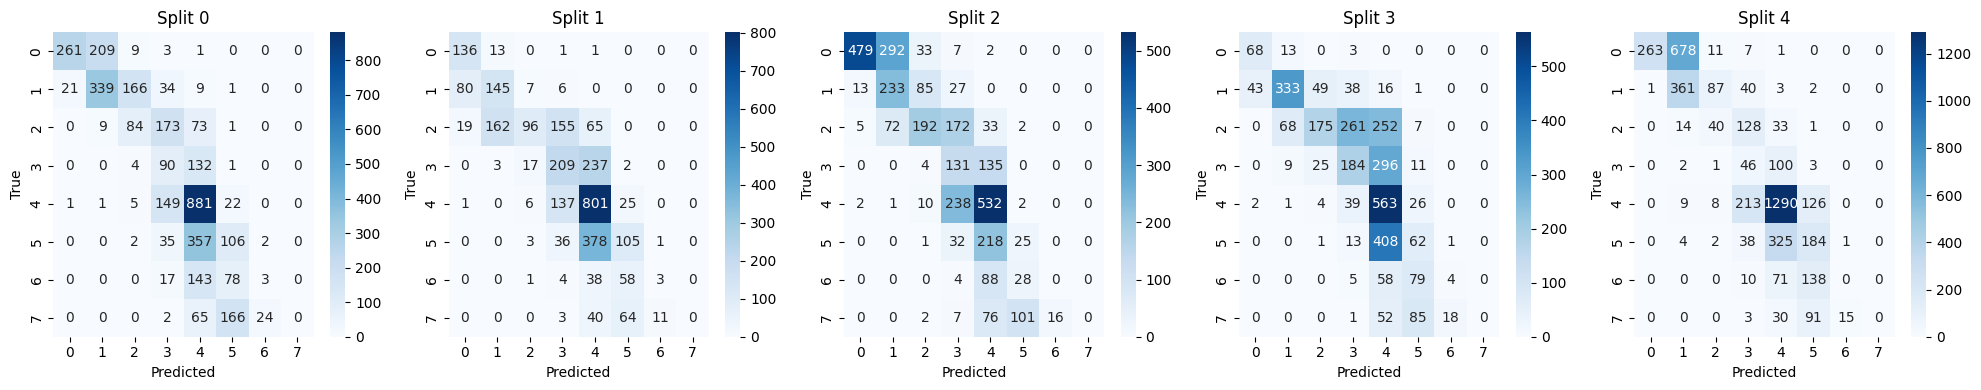



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl
split0 accuracy/class-wise-accuracy	=	0.5235 / 0.6977, 0.6860, 0.2265, 0.4141, 0.8281, 0.2829, 0.0332, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5152 / 0.8146, 0.8445, 0.3139, 0.4850, 0.7557, 0.2658, 0.0192, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4706 / 0.5166, 0.7765, 0.4601, 0.5667, 0.5401, 0.1848, 0.0333, 0.0198
split3 accuracy/class-wise-accuracy	=	0.3769 / 0.8095, 0.5354, 0.1796, 0.2400, 0.8425, 0.2247, 0.0137, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5877 / 0.6896, 0.6862, 0.3704, 0.3289, 0.7272, 0.4134, 0.0776, 0.0000

accuracy over splits: 0.4948  ± 0.0698

Classwise Mean Accuracy (Sorted):
Class 0: 0.7056 ± 0.1084
Class 1: 0.7057 ± 0.1040
Class 2: 0.3101 ± 0.1002
Class 3: 0.4070 ± 0.1146
Class 4: 0.7387 ± 0.1083
Class 5: 0.2743 ± 0.0774
Class 6: 0.0354 ± 0.0225
Class 7: 0.0040 ± 0.0079


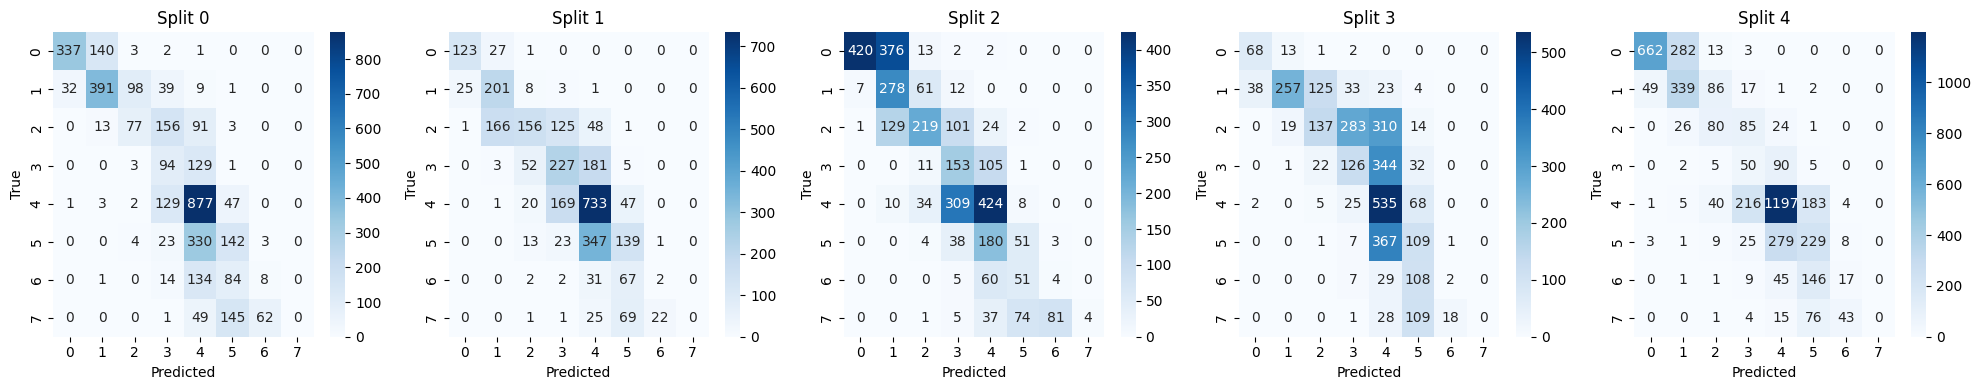



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v2
split0 accuracy/class-wise-accuracy	=	0.5058 / 0.6667, 0.7158, 0.2176, 0.2291, 0.8895, 0.1235, 0.0041, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5125 / 0.6490, 0.8950, 0.3481, 0.4017, 0.8546, 0.1281, 0.0481, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4576 / 0.4379, 0.6927, 0.2689, 0.2000, 0.8828, 0.1014, 0.0250, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3916 / 0.5476, 0.6646, 0.2372, 0.2362, 0.8409, 0.1402, 0.0685, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5712 / 0.5656, 0.6781, 0.2731, 0.2171, 0.8767, 0.1570, 0.0091, 0.0000

accuracy over splits: 0.4878  ± 0.0601

Classwise Mean Accuracy (Sorted):
Class 0: 0.5734 ± 0.0819
Class 1: 0.7292 ± 0.0846
Class 2: 0.2690 ± 0.0445
Class 3: 0.2568 ± 0.0735
Class 4: 0.8689 ± 0.0182
Class 5: 0.1301 ± 0.0184
Class 6: 0.0310 ± 0.0242
Class 7: 0.0000 ± 0.0000


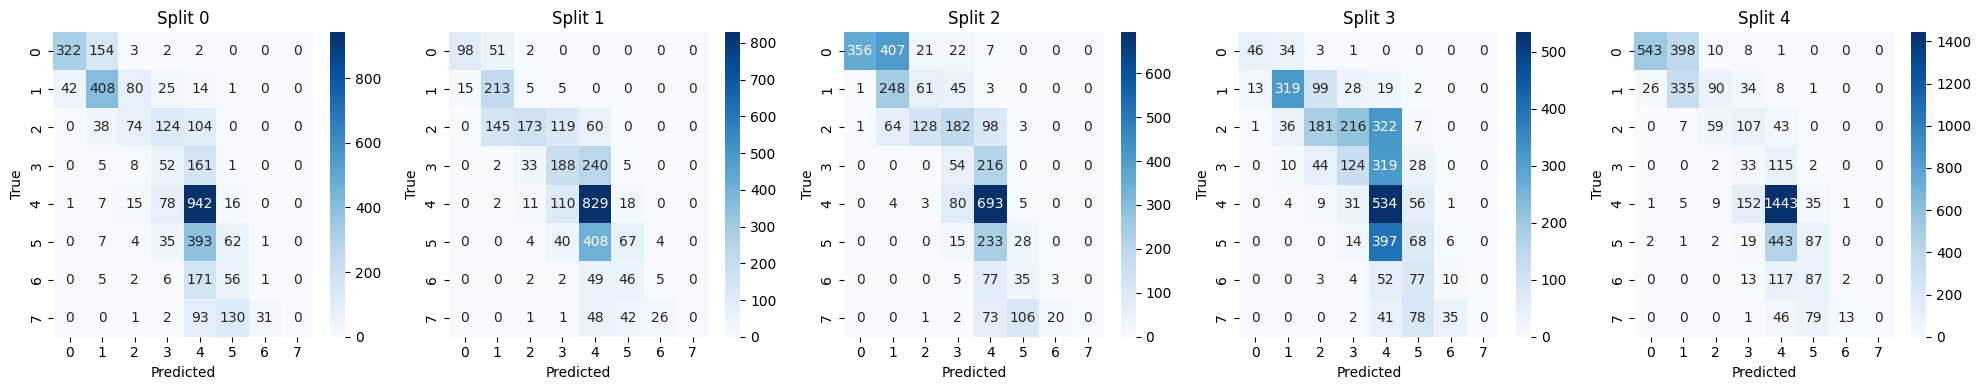



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v3
split0 accuracy/class-wise-accuracy	=	0.5393 / 0.7019, 0.8404, 0.1941, 0.2291, 0.8300, 0.2689, 0.1245, 0.0156
split1 accuracy/class-wise-accuracy	=	0.4558 / 0.8874, 0.5714, 0.2978, 0.2201, 0.6278, 0.4168, 0.4038, 0.0763
split2 accuracy/class-wise-accuracy	=	0.4855 / 0.5400, 0.7933, 0.4328, 0.2815, 0.6204, 0.3043, 0.1750, 0.0248
split3 accuracy/class-wise-accuracy	=	0.4081 / 0.4881, 0.7708, 0.2752, 0.2971, 0.7197, 0.1361, 0.2466, 0.0000
split4 accuracy/class-wise-accuracy	=	0.6151 / 0.7927, 0.6680, 0.4074, 0.1776, 0.7576, 0.2906, 0.3653, 0.0000

accuracy over splits: 0.5007  ± 0.0713

Classwise Mean Accuracy (Sorted):
Class 0: 0.6820 ± 0.1501
Class 1: 0.7288 ± 0.0968
Class 2: 0.3215 ± 0.0880
Class 3: 0.2411 ± 0.0433
Class 4: 0.7111 ± 0.0794
Class 5: 0.2834 ± 0.0897
Class 6: 0.2630 ± 0.1072
Class 7: 0.0233 ± 0.0281


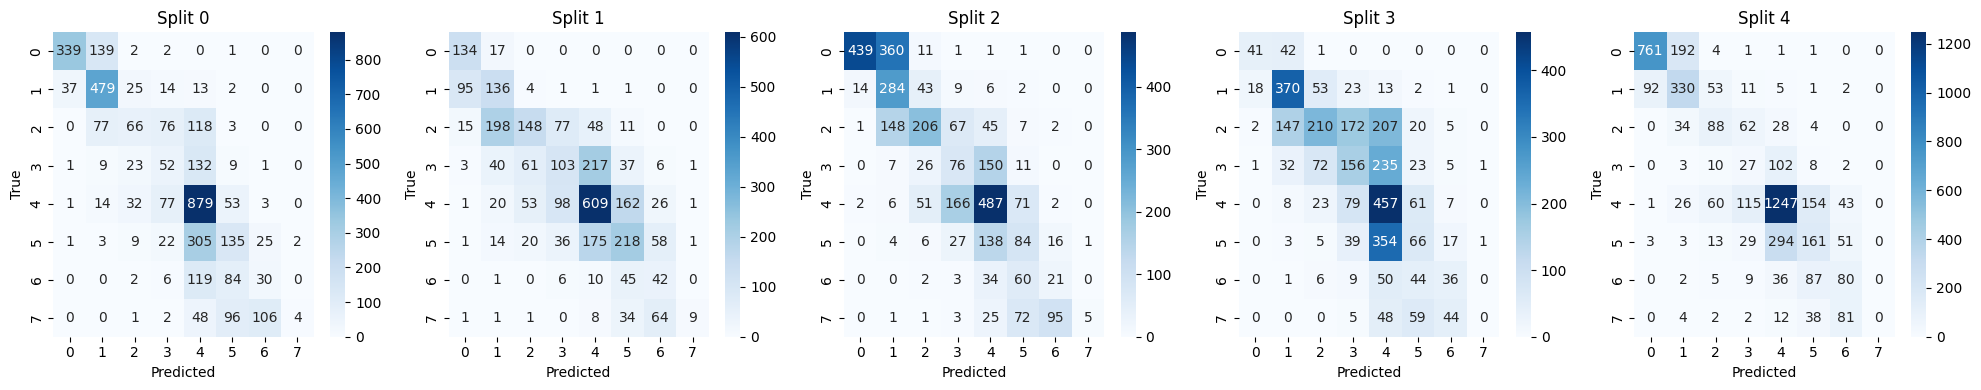



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v4
split0 accuracy/class-wise-accuracy	=	0.5031 / 0.6563, 0.7649, 0.3441, 0.3128, 0.6383, 0.3665, 0.1992, 0.0078
split1 accuracy/class-wise-accuracy	=	0.5011 / 0.8742, 0.6218, 0.3239, 0.3739, 0.6835, 0.3652, 0.3750, 0.2458
split2 accuracy/class-wise-accuracy	=	0.5164 / 0.6986, 0.6927, 0.4685, 0.3889, 0.5809, 0.3043, 0.1667, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4065 / 0.9286, 0.5500, 0.2936, 0.3124, 0.7260, 0.1794, 0.3562, 0.0064
split4 accuracy/class-wise-accuracy	=	0.5772 / 0.6740, 0.6235, 0.3009, 0.2171, 0.7321, 0.3718, 0.2785, 0.0216

accuracy over splits: 0.5009  ± 0.0547

Classwise Mean Accuracy (Sorted):
Class 0: 0.7663 ± 0.1124
Class 1: 0.6506 ± 0.0728
Class 2: 0.3462 ± 0.0637
Class 3: 0.3210 ± 0.0606
Class 4: 0.6722 ± 0.0567
Class 5: 0.3175 ± 0.0733
Class 6: 0.2751 ± 0.0826
Class 7: 0.0563 ± 0.0950


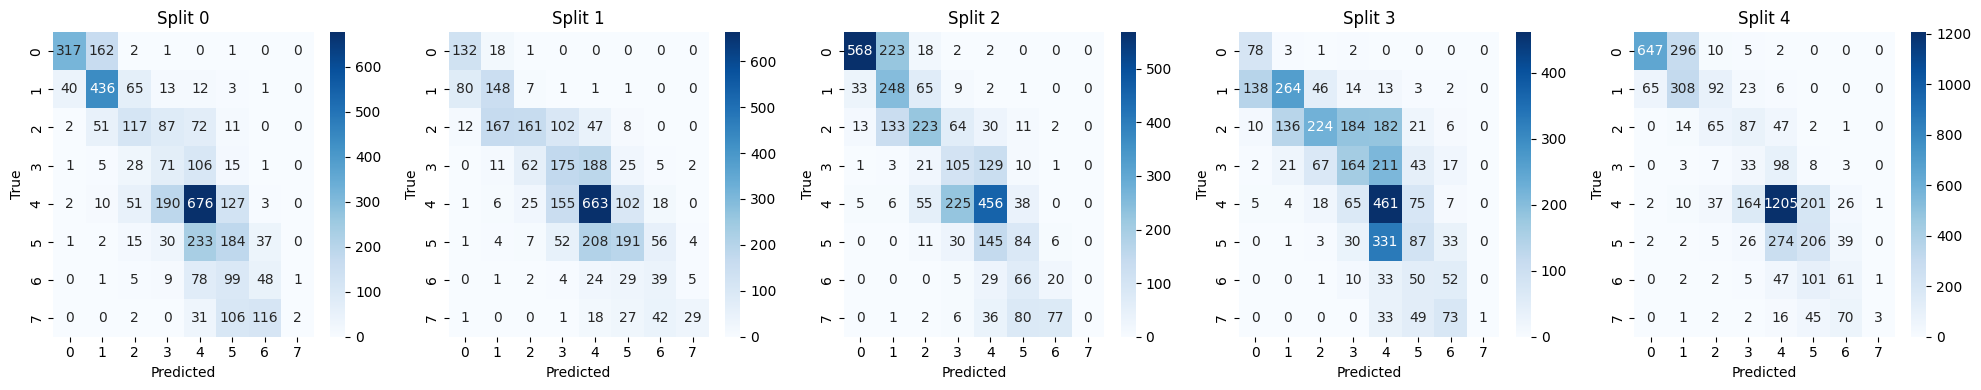



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v5
split0 accuracy/class-wise-accuracy	=	0.5300 / 0.6335, 0.8123, 0.3000, 0.2819, 0.7545, 0.3207, 0.1452, 0.0778
split1 accuracy/class-wise-accuracy	=	0.4904 / 0.9404, 0.4958, 0.2656, 0.3098, 0.7619, 0.3652, 0.3365, 0.0254
split2 accuracy/class-wise-accuracy	=	0.5164 / 0.5843, 0.7961, 0.4013, 0.2926, 0.6739, 0.3768, 0.3333, 0.0050
split3 accuracy/class-wise-accuracy	=	0.4090 / 0.8452, 0.5854, 0.2438, 0.3619, 0.7402, 0.2021, 0.2808, 0.0128
split4 accuracy/class-wise-accuracy	=	0.5845 / 0.6479, 0.7308, 0.3426, 0.1645, 0.7783, 0.3123, 0.1050, 0.0072

accuracy over splits: 0.5060  ± 0.0574

Classwise Mean Accuracy (Sorted):
Class 0: 0.7303 ± 0.1377
Class 1: 0.6841 ± 0.1236
Class 2: 0.3106 ± 0.0563
Class 3: 0.2821 ± 0.0649
Class 4: 0.7417 ± 0.0361
Class 5: 0.3154 ± 0.0619
Class 6: 0.2402 ± 0.0968
Class 7: 0.0256 ± 0.0270


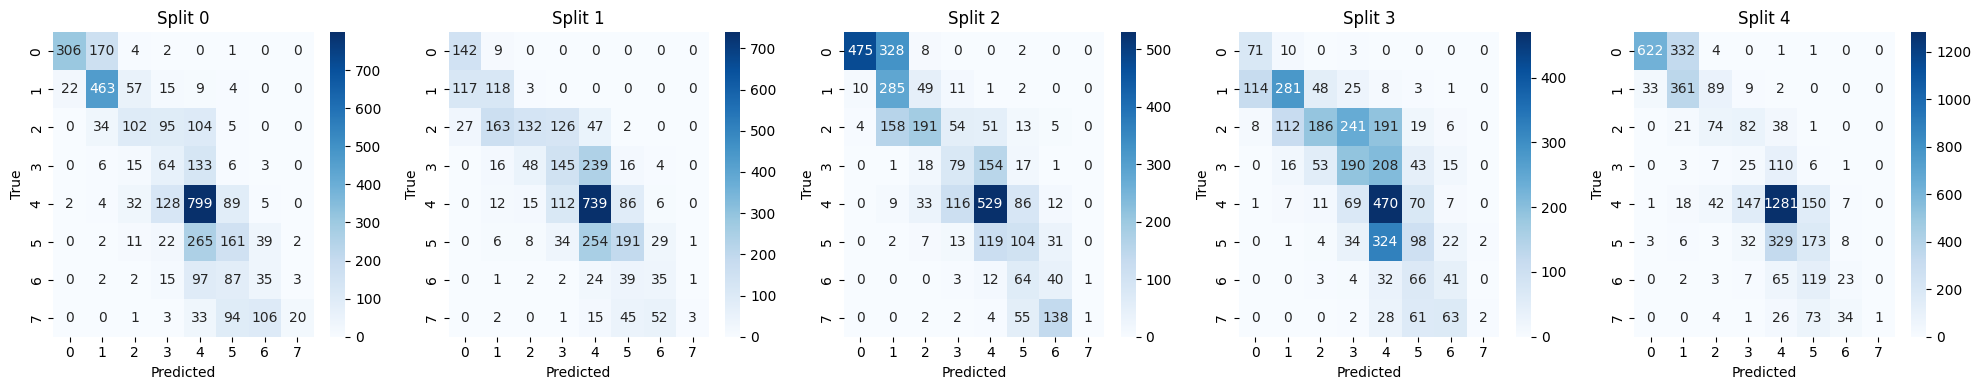



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_high_alpha
split0 accuracy/class-wise-accuracy	=	0.4985 / 0.7308, 0.4702, 0.2294, 0.4317, 0.8536, 0.2530, 0.0249, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5165 / 0.8675, 0.7647, 0.3702, 0.5150, 0.7237, 0.2600, 0.0865, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4400 / 0.3702, 0.6061, 0.5903, 0.5148, 0.5401, 0.2283, 0.1583, 0.0396
split3 accuracy/class-wise-accuracy	=	0.4102 / 0.7738, 0.5375, 0.2569, 0.4114, 0.7354, 0.2268, 0.1781, 0.0321
split4 accuracy/class-wise-accuracy	=	0.5422 / 0.4010, 0.7510, 0.3750, 0.2763, 0.7424, 0.4657, 0.0731, 0.0000

accuracy over splits: 0.4815  ± 0.0490

Classwise Mean Accuracy (Sorted):
Class 0: 0.6287 ± 0.2036
Class 1: 0.6259 ± 0.1161
Class 2: 0.3644 ± 0.1273
Class 3: 0.4298 ± 0.0876
Class 4: 0.7191 ± 0.1010
Class 5: 0.2868 ± 0.0904
Class 6: 0.1042 ± 0.0565
Class 7: 0.0143 ± 0.0177


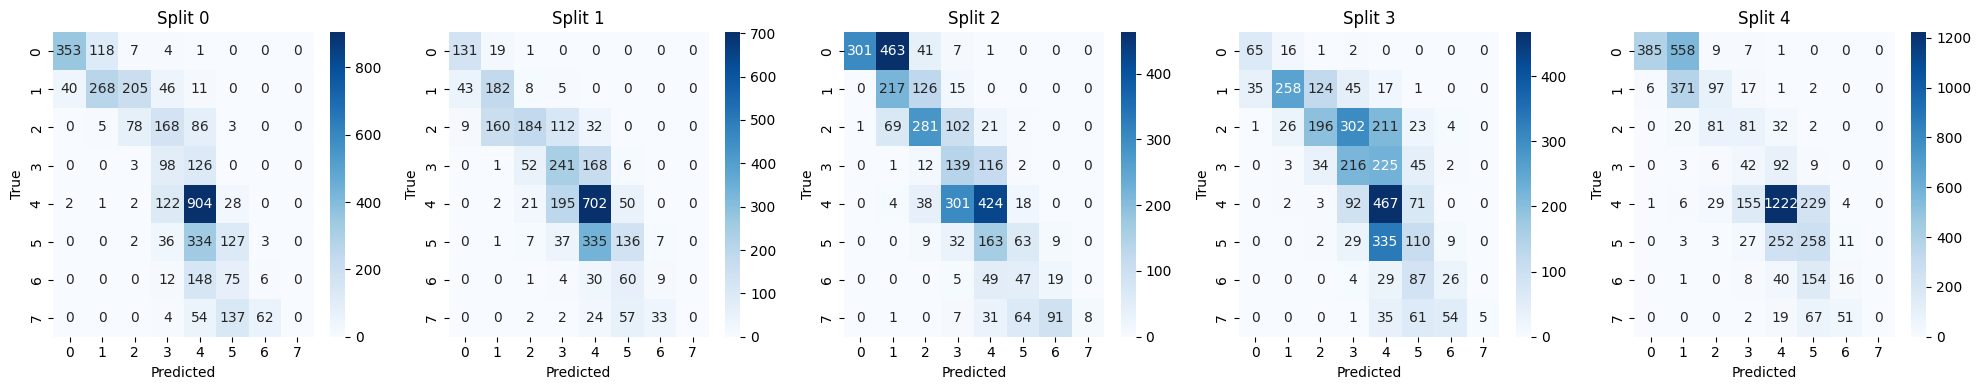



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl
split0 accuracy/class-wise-accuracy	=	0.5001 / 0.5756, 0.7193, 0.2971, 0.5903, 0.7686, 0.1853, 0.0415, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5292 / 0.8543, 0.7605, 0.3038, 0.4316, 0.8103, 0.3270, 0.0385, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4918 / 0.4686, 0.8045, 0.4286, 0.4111, 0.6841, 0.3406, 0.0667, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4279 / 0.8333, 0.6354, 0.2818, 0.2819, 0.8220, 0.2639, 0.0890, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5708 / 0.6312, 0.7368, 0.4028, 0.3421, 0.7503, 0.2653, 0.0411, 0.0000

accuracy over splits: 0.5040  ± 0.0470

Classwise Mean Accuracy (Sorted):
Class 0: 0.6726 ± 0.1494
Class 1: 0.7313 ± 0.0558
Class 2: 0.3428 ± 0.0605
Class 3: 0.4114 ± 0.1039
Class 4: 0.7671 ± 0.0491
Class 5: 0.2764 ± 0.0552
Class 6: 0.0554 ± 0.0197
Class 7: 0.0000 ± 0.0000


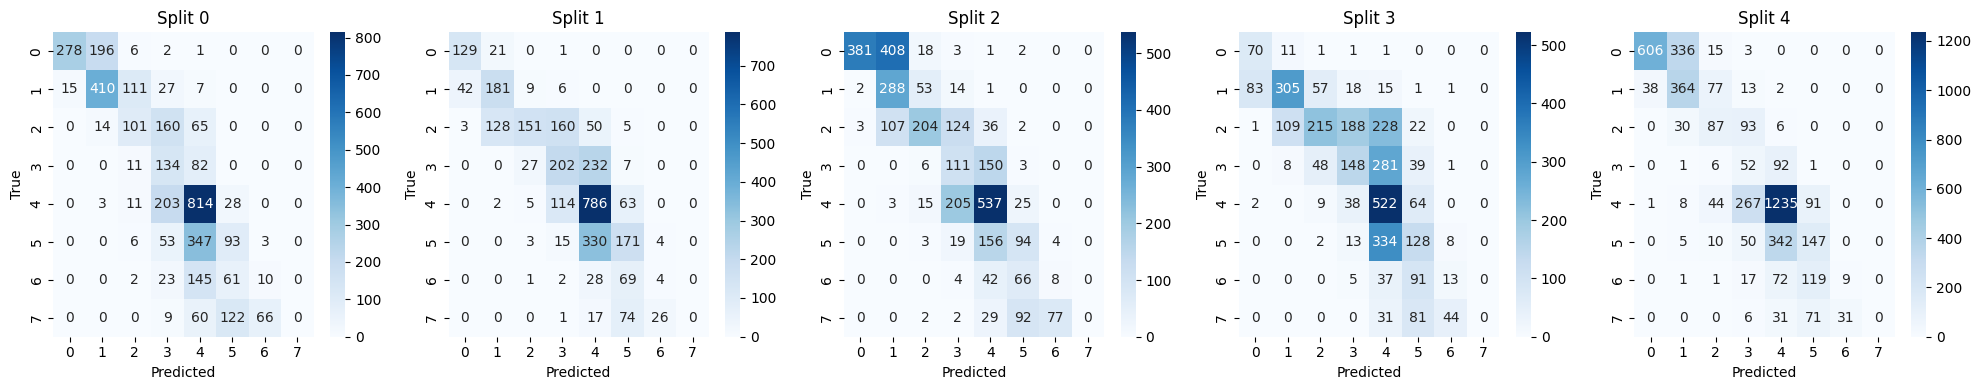



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl_v2
split0 accuracy/class-wise-accuracy	=	0.5235 / 0.6977, 0.6860, 0.2265, 0.4141, 0.8281, 0.2829, 0.0332, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5152 / 0.8146, 0.8445, 0.3139, 0.4850, 0.7557, 0.2658, 0.0192, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4706 / 0.5166, 0.7765, 0.4601, 0.5667, 0.5401, 0.1848, 0.0333, 0.0198
split3 accuracy/class-wise-accuracy	=	0.3769 / 0.8095, 0.5354, 0.1796, 0.2400, 0.8425, 0.2247, 0.0137, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5877 / 0.6896, 0.6862, 0.3704, 0.3289, 0.7272, 0.4134, 0.0776, 0.0000

accuracy over splits: 0.4948  ± 0.0698

Classwise Mean Accuracy (Sorted):
Class 0: 0.7056 ± 0.1084
Class 1: 0.7057 ± 0.1040
Class 2: 0.3101 ± 0.1002
Class 3: 0.4070 ± 0.1146
Class 4: 0.7387 ± 0.1083
Class 5: 0.2743 ± 0.0774
Class 6: 0.0354 ± 0.0225
Class 7: 0.0040 ± 0.0079


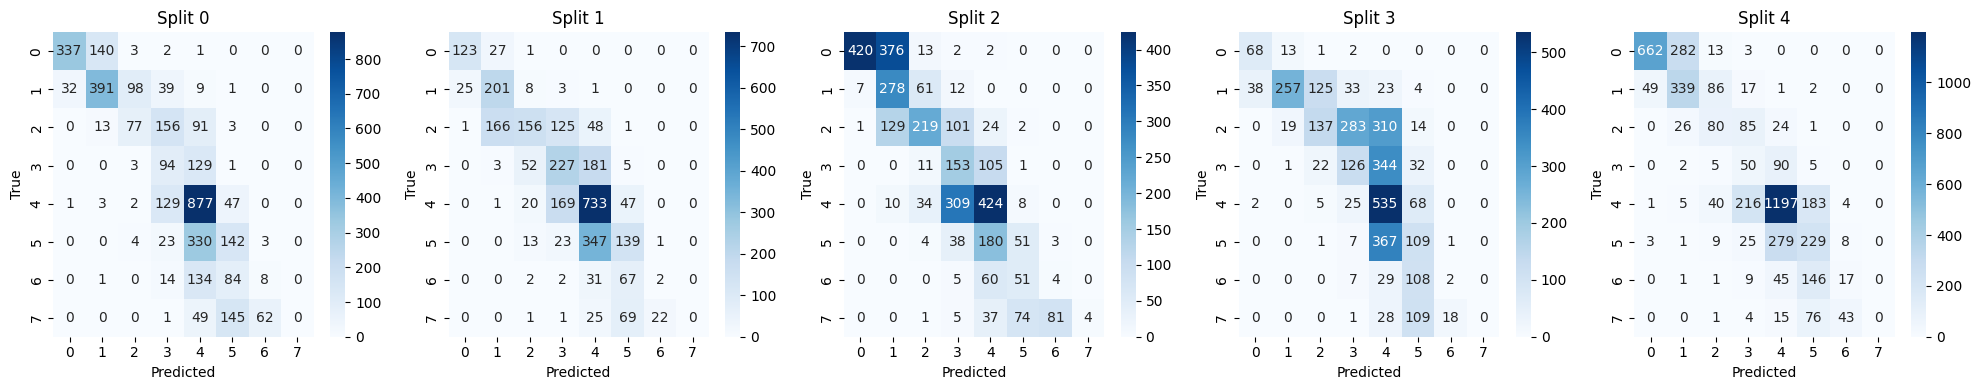



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl
split0 accuracy/class-wise-accuracy	=	0.4735 / 0.5569, 0.6772, 0.2971, 0.3656, 0.6638, 0.2908, 0.1867, 0.0350
split1 accuracy/class-wise-accuracy	=	0.4689 / 0.8344, 0.6008, 0.3159, 0.3184, 0.6485, 0.3480, 0.2596, 0.2203
split2 accuracy/class-wise-accuracy	=	0.4267 / 0.4945, 0.6117, 0.3697, 0.3630, 0.5096, 0.2210, 0.1750, 0.1535
split3 accuracy/class-wise-accuracy	=	0.4032 / 0.8333, 0.5938, 0.2595, 0.2533, 0.6299, 0.2928, 0.2740, 0.3333
split4 accuracy/class-wise-accuracy	=	0.4817 / 0.4531, 0.5668, 0.3796, 0.2632, 0.6118, 0.4170, 0.1416, 0.0288

accuracy over splits: 0.4508  ± 0.0305

Classwise Mean Accuracy (Sorted):
Class 0: 0.6345 ± 0.1662
Class 1: 0.6101 ± 0.0367
Class 2: 0.3244 ± 0.0450
Class 3: 0.3127 ± 0.0476
Class 4: 0.6127 ± 0.0545
Class 5: 0.3139 ± 0.0654
Class 6: 0.2074 ± 0.0509
Class 7: 0.1542 ± 0.1152


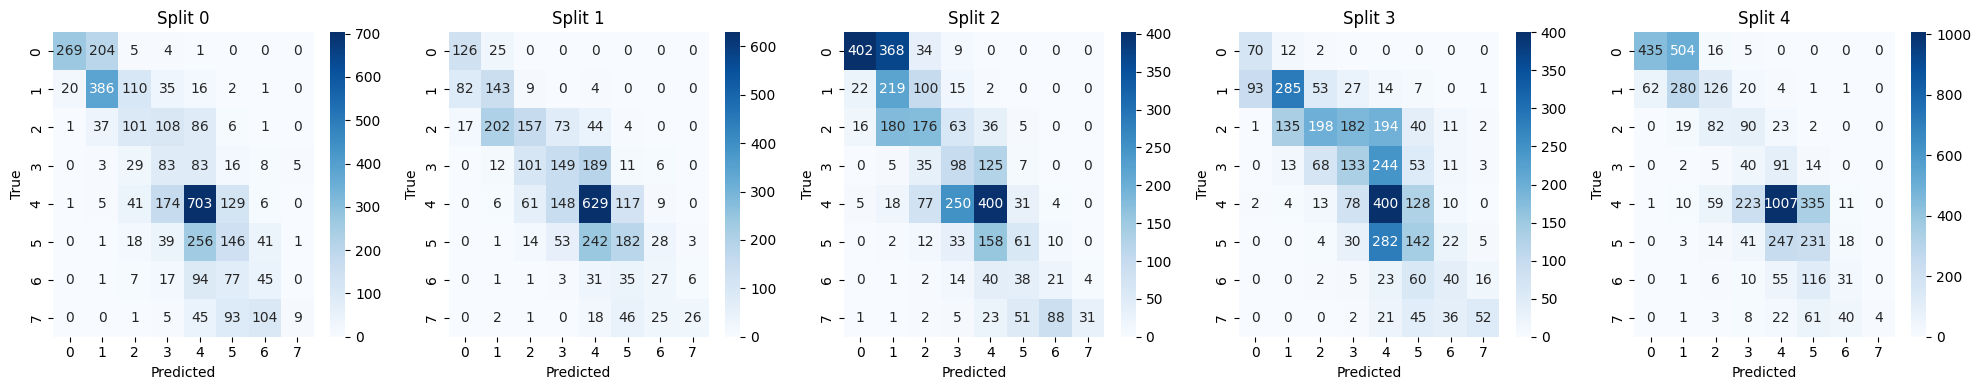



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v2
split0 accuracy/class-wise-accuracy	=	0.4735 / 0.5569, 0.6772, 0.2971, 0.3656, 0.6638, 0.2908, 0.1867, 0.0350
split1 accuracy/class-wise-accuracy	=	0.4444 / 0.8874, 0.2941, 0.2817, 0.4637, 0.6165, 0.2696, 0.2981, 0.2797
split2 accuracy/class-wise-accuracy	=	0.4267 / 0.4945, 0.6117, 0.3697, 0.3630, 0.5096, 0.2210, 0.1750, 0.1535
split3 accuracy/class-wise-accuracy	=	0.3974 / 0.8571, 0.5292, 0.2621, 0.2667, 0.7291, 0.1938, 0.3151, 0.2051
split4 accuracy/class-wise-accuracy	=	0.4817 / 0.4531, 0.5668, 0.3796, 0.2632, 0.6118, 0.4170, 0.1416, 0.0288

accuracy over splits: 0.4447  ± 0.0309

Classwise Mean Accuracy (Sorted):
Class 0: 0.6498 ± 0.1849
Class 1: 0.5358 ± 0.1305
Class 2: 0.3180 ± 0.0477
Class 3: 0.3444 ± 0.0744
Class 4: 0.6262 ± 0.0720
Class 5: 0.2784 ± 0.0773
Class 6: 0.2233 ± 0.0698
Class 7: 0.1404 ± 0.0973


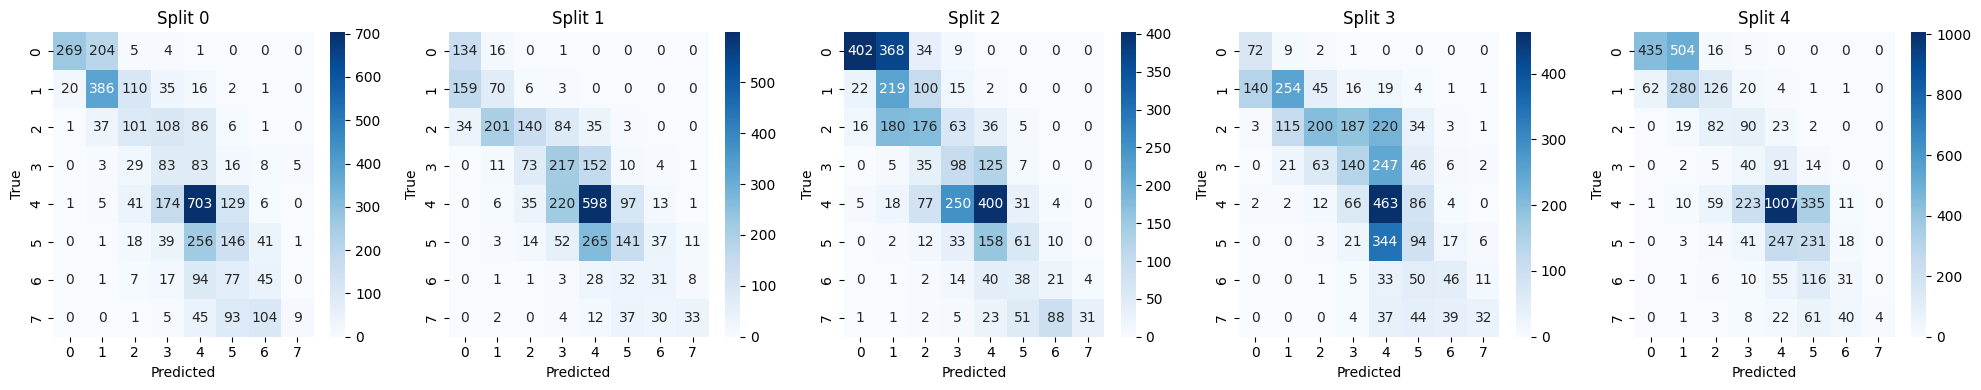



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3
split0 accuracy/class-wise-accuracy	=	0.5159 / 0.7909, 0.6404, 0.2235, 0.2996, 0.6572, 0.3904, 0.2780, 0.1868
split1 accuracy/class-wise-accuracy	=	0.4373 / 0.9139, 0.2983, 0.1952, 0.4274, 0.6258, 0.2964, 0.3750, 0.2966
split2 accuracy/class-wise-accuracy	=	0.5370 / 0.6556, 0.8296, 0.3655, 0.3704, 0.5745, 0.3261, 0.3500, 0.4208
split3 accuracy/class-wise-accuracy	=	0.4151 / 0.8214, 0.6083, 0.3250, 0.4190, 0.5575, 0.1897, 0.3082, 0.2500
split4 accuracy/class-wise-accuracy	=	0.6164 / 0.8365, 0.5385, 0.2778, 0.1908, 0.7296, 0.4152, 0.3973, 0.1727

accuracy over splits: 0.5043  ± 0.0724

Classwise Mean Accuracy (Sorted):
Class 0: 0.8037 ± 0.0844
Class 1: 0.5830 ± 0.1719
Class 2: 0.2774 ± 0.0628
Class 3: 0.3414 ± 0.0880
Class 4: 0.6289 ± 0.0617
Class 5: 0.3235 ± 0.0794
Class 6: 0.3417 ± 0.0435
Class 7: 0.2654 ± 0.0896


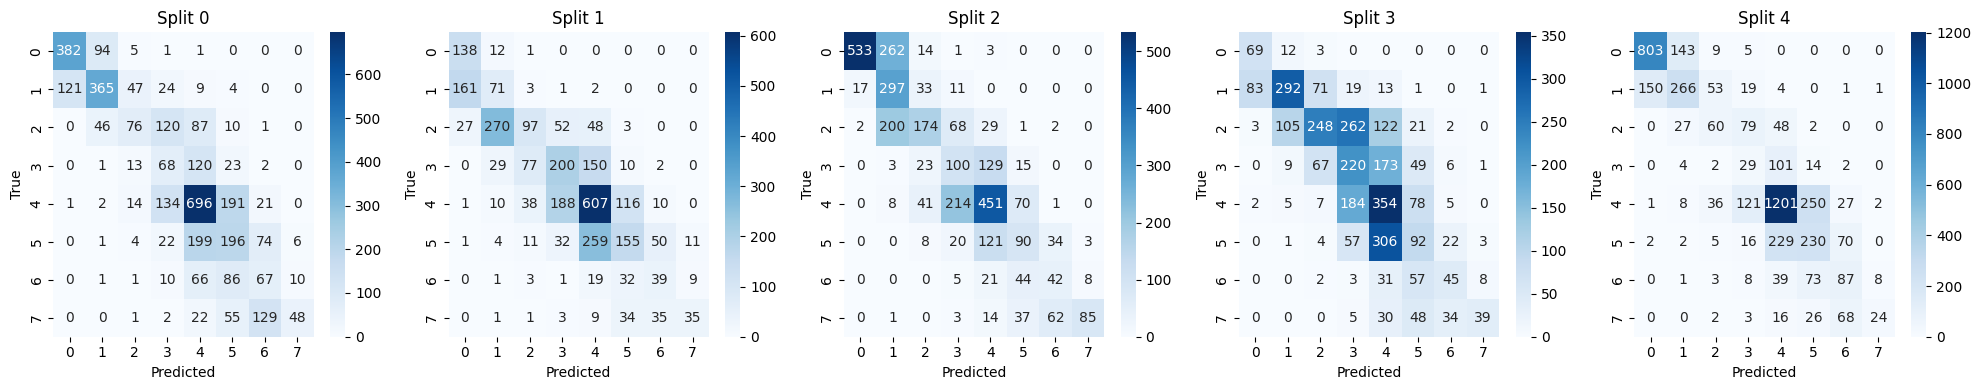



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smed_carl_v2
split0 accuracy/class-wise-accuracy	=	0.5143 / 0.6087, 0.7105, 0.3412, 0.3436, 0.6544, 0.3884, 0.1950, 0.2490
split1 accuracy/class-wise-accuracy	=	0.4894 / 0.8411, 0.7983, 0.5996, 0.5449, 0.4227, 0.2983, 0.3558, 0.2458
split2 accuracy/class-wise-accuracy	=	0.4603 / 0.4859, 0.8017, 0.5546, 0.4185, 0.2904, 0.3877, 0.3500, 0.4109
split3 accuracy/class-wise-accuracy	=	0.4291 / 0.5952, 0.6354, 0.3919, 0.3448, 0.5874, 0.2392, 0.2877, 0.2500
split4 accuracy/class-wise-accuracy	=	0.5299 / 0.6708, 0.5870, 0.3935, 0.5329, 0.5747, 0.2708, 0.4384, 0.2086

accuracy over splits: 0.4846  ± 0.0364

Classwise Mean Accuracy (Sorted):
Class 0: 0.6403 ± 0.1167
Class 1: 0.7066 ± 0.0858
Class 2: 0.4562 ± 0.1015
Class 3: 0.4369 ± 0.0876
Class 4: 0.5059 ± 0.1317
Class 5: 0.3169 ± 0.0611
Class 6: 0.3254 ± 0.0809
Class 7: 0.2729 ± 0.0707


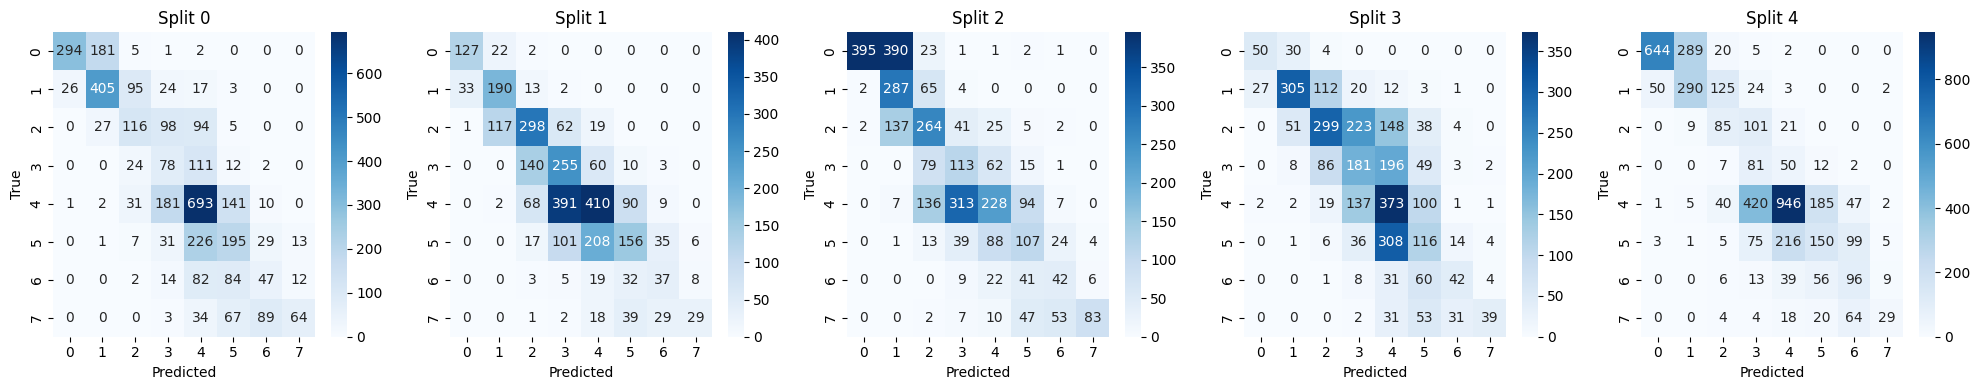



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3
split0 accuracy/class-wise-accuracy	=	0.5893 / 0.8447, 0.6807, 0.5029, 0.2247, 0.7403, 0.4761, 0.2780, 0.2335
split1 accuracy/class-wise-accuracy	=	0.5940 / 0.8808, 0.7437, 0.4990, 0.4551, 0.7103, 0.5449, 0.4615, 0.2542
split2 accuracy/class-wise-accuracy	=	0.6533 / 0.7515, 0.8520, 0.4706, 0.4667, 0.7643, 0.5000, 0.4167, 0.5050
split3 accuracy/class-wise-accuracy	=	0.5434 / 0.8214, 0.7125, 0.4482, 0.5295, 0.7890, 0.3134, 0.2397, 0.3846
split4 accuracy/class-wise-accuracy	=	0.6605 / 0.7406, 0.8441, 0.6343, 0.4145, 0.6908, 0.4838, 0.4977, 0.3669

accuracy over splits: 0.6081  ± 0.0437

Classwise Mean Accuracy (Sorted):
Class 0: 0.8078 ± 0.0540
Class 1: 0.7666 ± 0.0695
Class 2: 0.5110 ± 0.0648
Class 3: 0.4181 ± 0.1035
Class 4: 0.7389 ± 0.0355
Class 5: 0.4636 ± 0.0788
Class 6: 0.3787 ± 0.1019
Class 7: 0.3488 ± 0.0982


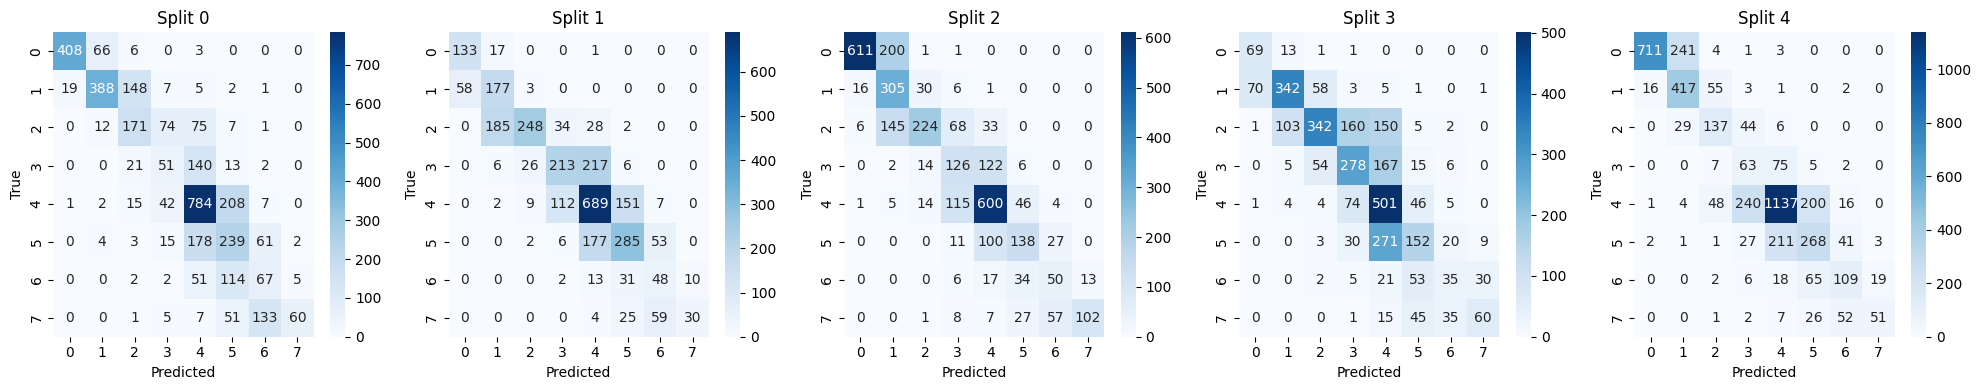



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3_noisy_test
split0 accuracy/class-wise-accuracy	=	0.3566 / 0.5916, 0.4342, 0.1140, 0.1621, 0.5806, 0.3217, 0.1840, 0.1016
split1 accuracy/class-wise-accuracy	=	0.3040 / 0.4291, 0.2136, 0.1395, 0.3207, 0.5706, 0.2370, 0.1300, 0.1014
split2 accuracy/class-wise-accuracy	=	0.3924 / 0.5481, 0.5665, 0.2473, 0.2465, 0.4930, 0.2067, 0.2010, 0.2583
split3 accuracy/class-wise-accuracy	=	0.2831 / 0.2026, 0.4028, 0.2358, 0.3340, 0.4481, 0.1651, 0.1405, 0.1288
split4 accuracy/class-wise-accuracy	=	0.4021 / 0.6766, 0.3201, 0.0964, 0.0805, 0.6568, 0.3043, 0.1949, 0.0667

accuracy over splits: 0.3476  ± 0.0471

Classwise Mean Accuracy (Sorted):
Class 0: 0.4896 ± 0.1642
Class 1: 0.3874 ± 0.1177
Class 2: 0.1666 ± 0.0628
Class 3: 0.2288 ± 0.0962
Class 4: 0.5498 ± 0.0726
Class 5: 0.2469 ± 0.0588
Class 6: 0.1701 ± 0.0291
Class 7: 0.1313 ± 0.0665


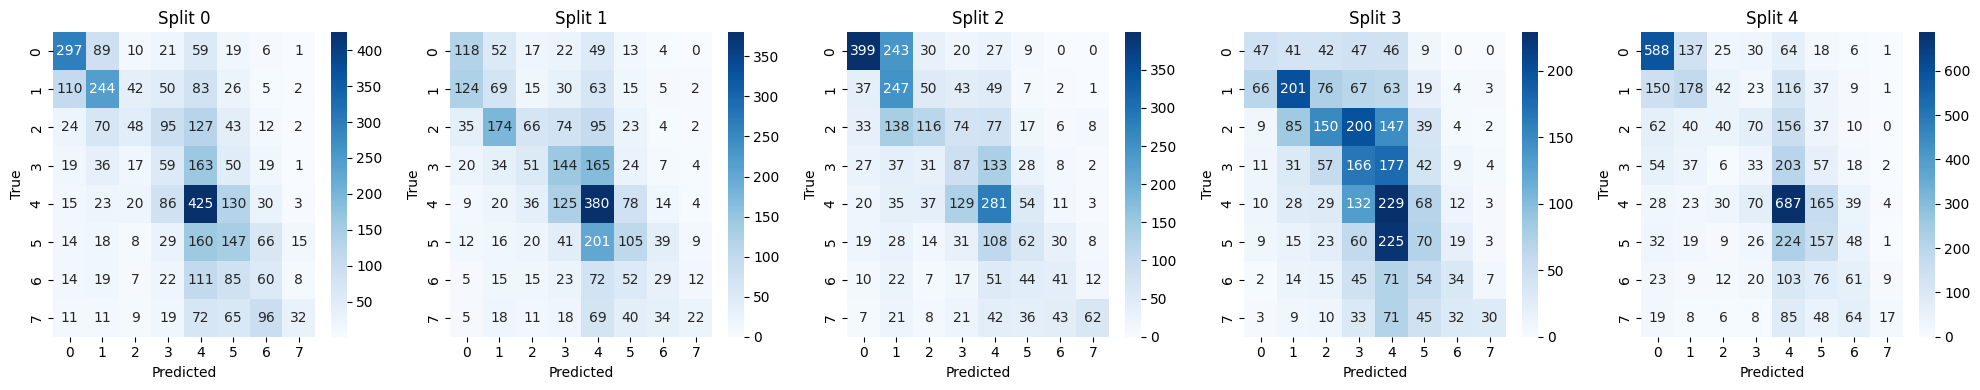



Experiment: Adience_256x256_resnet50_imagenet_dldl_v2_noisy_test
split0 accuracy/class-wise-accuracy	=	0.3414 / 0.5857, 0.3843, 0.2114, 0.2060, 0.5765, 0.2604, 0.0890, 0.0381
split1 accuracy/class-wise-accuracy	=	0.3001 / 0.3709, 0.2539, 0.2622, 0.3452, 0.4940, 0.1874, 0.1570, 0.0507
split2 accuracy/class-wise-accuracy	=	0.3124 / 0.2734, 0.5206, 0.2367, 0.1275, 0.5474, 0.2300, 0.2157, 0.1000
split3 accuracy/class-wise-accuracy	=	0.2453 / 0.1164, 0.2926, 0.1934, 0.1871, 0.5558, 0.1816, 0.1694, 0.0515
split4 accuracy/class-wise-accuracy	=	0.3158 / 0.3659, 0.3813, 0.2048, 0.1415, 0.5076, 0.3120, 0.0511, 0.0078

accuracy over splits: 0.3030  ± 0.0318

Classwise Mean Accuracy (Sorted):
Class 0: 0.3424 ± 0.1526
Class 1: 0.3665 ± 0.0921
Class 2: 0.2217 ± 0.0247
Class 3: 0.2015 ± 0.0774
Class 4: 0.5363 ± 0.0308
Class 5: 0.2343 ± 0.0484
Class 6: 0.1364 ± 0.0589
Class 7: 0.0496 ± 0.0297


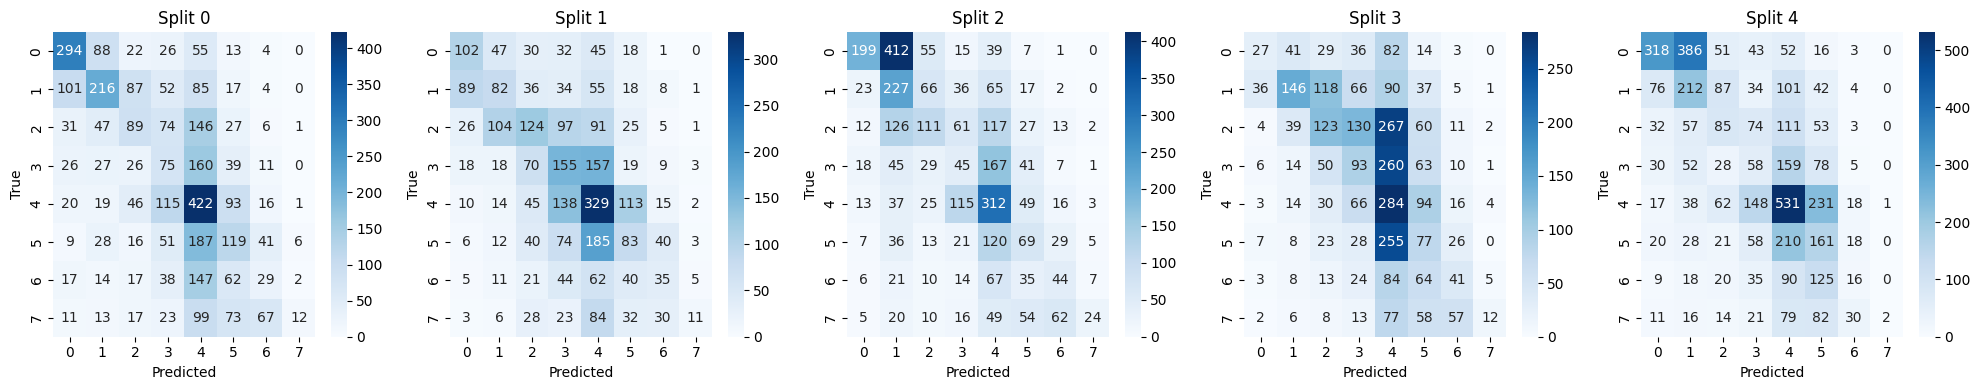

In [3]:
data_root = '../facebase/data'
result_root = '../facebase/results'
experiments = ['Adience_256x256_resnet50_imagenet_dldl_v2_clean',
               'Adience_256x256_resnet50_imagenet_dldl_v2_noisy',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_carl',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v4',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v5',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_sigma',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_mean',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip_v2',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v2',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v3',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v4',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_v5',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_carl_high_alpha',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_fcarl_v2',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v2',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smed_carl_v2',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_smcarl_v3',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl_v3_noisy_test',
               'Adience_256x256_resnet50_imagenet_dldl_v2_noisy_test'
               ]

report_accuracy(data_root, result_root, experiments)